### Use a pretrained image-classifier to find for each test image it's Nearest Neighbor train image,in the underlying latent (feauture) space. Then associate to the test image a random utterance (annotation) created for the its corresponding neighbor.
    - Saves the results in a csv file
    - The notebook is quite simple as all the heavy lifting happens in the imported classes
    - IMHO, the results here are impressive (i.e., fitting on average) and this highlights further that 
    emotion-explanaing is really a subjective and open-ended task.    

In [1]:
import torch
import numpy as np
import pandas as pd
import os.path as osp
from PIL import Image

from artemis.analysis.feature_extraction import extract_visual_features
from artemis.neural_models.distances import k_euclidean_neighbors
from artemis.in_out.basics import unpickle_data, splitall, pickle_data

In [2]:
## Change to YOUR PATHS
wiki_art_img_dir = '/home/optas/DATA/Images/Wiki-Art/rescaled_max_size_to_600px_same_aspect_ratio'
references_file = '/home/optas/DATA/OUT/artemis/preprocessed_data/for_neural_nets/artemis_gt_references_grouped.pkl'
save_file = '/home/optas/DATA/OUT/artemis/neural_nets/speakers/nearest_neighbor/samples_from_best_model_test_split.pkl'

In [3]:
method = 'resnet34'  # you could use resnet101, vgg etc. see extract_visual_features.py
img_dim = 256        # size to rescale each image
gpu_id = '3'
random_seed = 2021
save_results = True

In [4]:
gt_data = next(unpickle_data(references_file))
train_data = gt_data['train']
test_data = gt_data['test']
print('Train N-Images vs. Test N-Images', len(train_data), len(test_data))

In [5]:
train_images = wiki_art_img_dir + '/' + train_data.art_style + '/' + train_data.painting + '.jpg'
test_images  = wiki_art_img_dir + '/' + test_data.art_style  + '/' + test_data.painting  + '.jpg'

In [6]:
assert len(set(train_images)) == len(train_images)
assert len(set(test_images)) == len(test_images)

In [7]:
# Extract features 
device = torch.device("cuda:" + gpu_id)
train_feats = extract_visual_features(train_images, img_dim, method=method, device=device)
test_feats = extract_visual_features(test_images, img_dim, method=method, device=device)

In [8]:
# Push features to GPU to do nearest-neighbors
train_feats = torch.from_numpy(train_feats).to(device)
test_feats = torch.from_numpy(test_feats).to(device)
n_dists, n_ids = k_euclidean_neighbors(2, test_feats, train_feats)  # take 2 nearest-neigbhs to remove possible dups

In [9]:
# replace duplicate (among train/test) with 2nd NN
# this should be obsolete, since I de-duplicated the entire WikiArt on version#2 (CVPR)
# but if you are applying to another dataset it is not a bad idea
# (sorry do not have time to beautify this up now...)

f_ids = n_ids[:, 0]
f_dists = n_dists[:, 0]
too_close_mask = n_dists[:,0] < 1 # you can finetune this threshold
f_ids[too_close_mask] = n_ids[:, 1][too_close_mask]    #F : final ids
f_dists[too_close_mask] = n_dists[:,1][too_close_mask]
print((f_dists < 1).sum()) 
f_ids = f_ids.cpu().numpy()
f_dists = f_dists.cpu().numpy()

tensor(0, device='cuda:3')


TEST


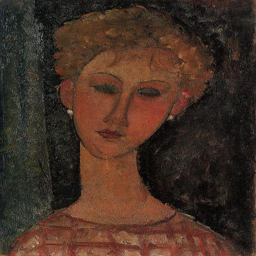

TRAIN


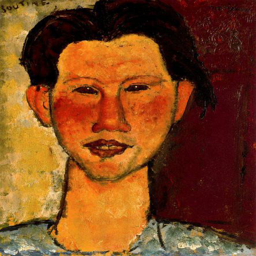

'the person just looks weirdly proportioned so it just makes me uncomfortable'

In [10]:
# visualize random pair with random utterance
r = np.random.randint(len(test_images))
print('TEST')
display(Image.open(test_images[r]).resize((256, 256)))  

print('TRAIN')
fr = f_ids[r]
display(Image.open(train_images[fr]).resize((256, 256)))
lt = train_data.iloc[fr].references_pre_vocab
lt[np.random.choice(len(lt), 1)[0]] # show a random caption of the training

In [17]:
# Make a pandas dataframe with the corresponding captions (sorry do not have time to beautify this up now...)
all_p = []
all_a = []
all_u = []

np.random.seed(random_seed)

for r in range(len(test_images)):
    toks = splitall(test_images[r])
    a_painting = toks[-1][:-len('.jpg')]
    a_style = toks[-2]
    all_p.append(a_painting)
    all_a.append(a_style)
    fr = f_ids[r]
    lt = train_data.iloc[fr].references_pre_vocab
    utter = lt[np.random.choice(len(lt), 1)[0]]    # pick randomly one
    all_u.append(utter)
    
all_p = pd.DataFrame(all_p)
all_a = pd.DataFrame(all_a)
all_u = pd.DataFrame(all_u)
nn_captions = pd.concat([all_a, all_p, pd.Series([None] * len(all_u)), all_u], axis=1)
nn_captions.columns = ['art_style', 'painting', 'grounding_emotion', 'caption']

In [19]:
# Optional, if you want to align the NN-captions with those of another generated set. (useful for Panos to compare in for loop fahsion )
if False:
    sampled_captions_file = '/home/optas/DATA/OUT/artemis/neural_nets/speakers/default_training/03-16-2021-22-21-45/samples_from_best_model_test_split.pkl'
    caption_data = next(unpickle_data(sampled_captions_file))[0]
    sampling_config_details, other_captions, attn = caption_data  # here I use the captions as saved from the sample_speaker.py
    print(other_captions.head(2))
    
    cc = other_captions[['art_style', 'painting']]
    nn_captions = pd.merge(cc, nn_captions) # re-order according to the cc order
    
    assert all(other_captions.painting == nn_captions.painting)
    assert all(other_captions.art_style == nn_captions.art_style)

                art_style                      painting grounding_emotion  \
0  Abstract_Expressionism  aaron-siskind_chicago-6-1961              None   
1  Abstract_Expressionism   aaron-siskind_feet-102-1957              None   

                                 caption  
0      the lines are very dark and scary  
1  the black figure looks like a monster  


In [20]:
nn_captions.head()

,art_style,painting,grounding_emotion,caption
0,Abstract_Expressionism,aaron-siskind_chicago-6-1961,None,the ominous tones and dark shadows allude to s...
1,Abstract_Expressionism,aaron-siskind_feet-102-1957,None,there is a very disturbing nature in her long ...
2,Abstract_Expressionism,aaron-siskind_new-york-1951,None,the closeness of the streets and towering spir...
3,Abstract_Expressionism,aaron-siskind_westport-10-1988,None,the woman looks as though she has fallen aslee...
4,Abstract_Expressionism,adnan-coker_unknown-title(3),None,makes me feel like birds are flying over my head


this reminds me of a scene from the bible which comforts me


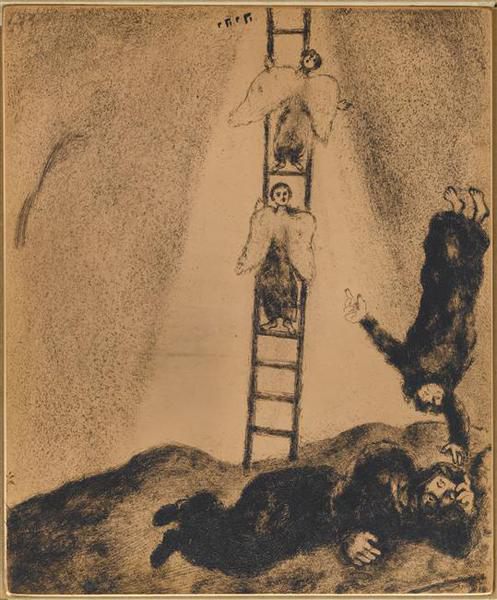

In [21]:
rs = nn_captions.sample(1)
print(rs['caption'].iloc[0])
display(Image.open(osp.join(wiki_art_img_dir, rs['art_style'].iloc[0], rs['painting'].iloc[0] + '.jpg')))        

In [23]:
if save_results:
    sampling_configuration = 'Nearest-Neighbor'
    atn_values = None
    pickle_data(save_file, [[sampling_configuration, nn_captions, atn_values]])